# Smart Home Energy Analysis with Prophet
This kernel focuses  on these things
* ## Time Series Analysis with Prophet
* ## Data Visualization with seaborn

For my dataset, I use 'smart-meters-in-London' dataset. Thank you for this great dataset.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the '../input/' directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# import os
# print(os.listdir('../input'))

# Any results you write to the current directory are saved as output.

In [2]:
%run 'functions.py'

In [3]:
# import some libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()
# %matplotlib inline

# 1 House Analysis
From now on, I use only 1 house data for my analysis

In [ ]:
pip install pystan==2.19.1.1

In [ ]:
pip install prophet

In [4]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

Importing plotly failed. Interactive plots will not work.


In [ ]:
block_0_df.head()

In [ ]:
block_0_df.dtypes

In [ ]:
# set energy consumption data to float type
block_0_df = block_0_df[block_0_df['energy(kWh/hh)'] != 'Null']
block_0_df['energy(kWh/hh)'] = block_0_df['energy(kWh/hh)'].astype('float64')

In [ ]:
# Choose only 1 house by LCLid 'MAC000002'
block_0_df = block_0_df[block_0_df['LCLid'] == 'MAC000002' ]

In [ ]:
# plot energy consumption data with dataframe module
block_0_df.plot(y='energy(kWh/hh)', figsize=(12, 4))

## Basic Prediction with Prophet

In [5]:
affluent_2012 = pd.read_csv('~/Downloads/control data/affluent_2012.csv', index_col='DT')
affluent_2013 = pd.read_csv('~/Downloads/control data/affluent_2013.csv', index_col='DT')

# set tstp to index with datetime type
affluent_2012.index = affluent_2012.index.astype('datetime64[ns]')
affluent_2013.index = affluent_2013.index.astype('datetime64[ns]')

In [8]:
affluent_weekdays_2012 = affluent_2012.loc[(affluent_2012['day_of_week']!=5) & (affluent_2012['day_of_week']!=6)]
affluent_weekends_2012 = affluent_2012.loc[(affluent_2012['day_of_week']==5) | (affluent_2012['day_of_week']==6)]

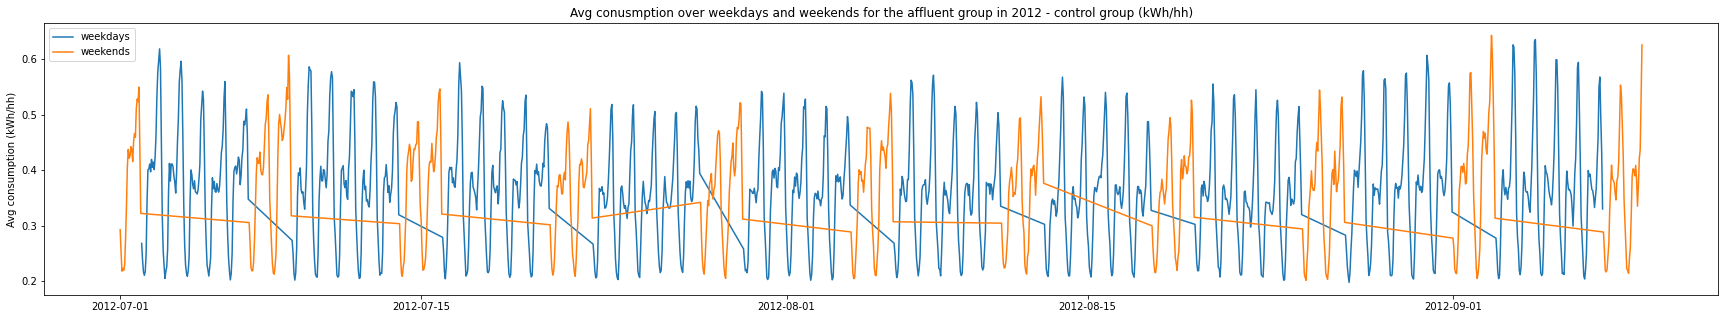

In [9]:
plt.figure(figsize=(30, 5))
plt.plot(affluent_weekdays_2012['kWh/hh'][:1200], label='weekdays')
plt.plot(affluent_weekends_2012['kWh/hh'][:500], label='weekends')
plt.title('Avg conusmption over weekdays and weekends for the affluent group in 2012 - control group (kWh/hh)')
plt.ylabel('Avg consumption (kWh/hh)')
plt.savefig('../figs/2012_aff_weekday_weekend.png')
plt.legend()
plt.show()

In [6]:
train_size = int(0.8 * len(affluent_2012))
X_train, X_test = affluent_2012[:train_size].index, affluent_2012[train_size:].index
y_train, y_test = affluent_2012[:train_size]['kWh/hh'].values, affluent_2012[train_size:]['kWh/hh'].values
reg_train, reg_test = affluent_2012[:train_size]['temp'].values, affluent_2012[train_size:]['temp'].values

train_df_2012 = pd.concat([pd.Series(X_train), pd.Series(y_train), pd.Series(reg_train)], axis=1, keys=['ds', 'y', 'temp'])
test_df_2012 = pd.concat([pd.Series(X_test), pd.Series([0]*len(y_test)), pd.Series(reg_test)], axis=1, keys=['ds', 'y', 'temp'])
answer_df_2012 = pd.concat([pd.Series(X_test), pd.Series(y_test)], axis=1, keys=['ds', 'y'])

In [54]:
holiday_df = pd.read_csv('../data/uk_bank_holidays.csv', names=('ds', 'holiday'), header=0)

In [7]:
# We have to add week and month seasonality
model = Prophet()
# model = Prophet(weekly_seasonality=True, daily_seasonality=True)
# model.add_regressor('temp')
# model.add_seasonality(name='monthly', period=30, fourier_order=5)
model.fit(train_df_2012);

# add daily seasonality
# model = Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=True, 
#                 growth='logistic', holidays=holiday_df, changepoint_prior_scale=0.2)
# train_df['cap'] = 0.25
# train_df['floor'] = 0.1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [8]:
# forecast_2012_w_reg = model.predict(test_df_2012)
forecast_2012 = model.predict(test_df_2012)

In [261]:
# let's compare error on test_df_2012 w reg and no reg
dif_w_reg = (answer_df_2012['y'] - forecast_2012_no_reg['yhat'])/answer_df_2012['y']
dif_no_reg = (answer_df_2012['y'] - forecast_2012_w_reg['yhat'])/answer_df_2012['y']

In [262]:
print('w reg', dif_w_reg.mean())
print('no reg', dif_no_reg.mean())

w reg -0.09945278665601141
no reg -0.09815632563978618


In [136]:
print('percent w reg', dif_w_reg.mean()*100)
print('percemt no reg', dif_no_reg.mean()*100)

percent w reg -5.811467816825688
percemt no reg -6.270993670942512


actual treatment 2012 ----> ??? counterfactual treatment 2013
|
|
actual control 2012  -----> actual control 2013

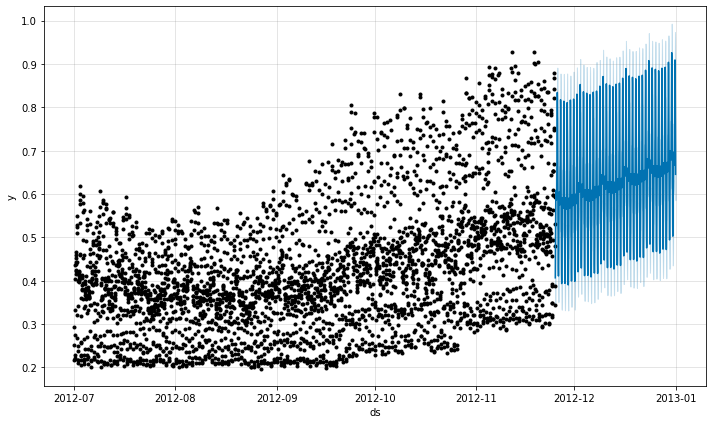

In [9]:
model.plot(forecast_2012);

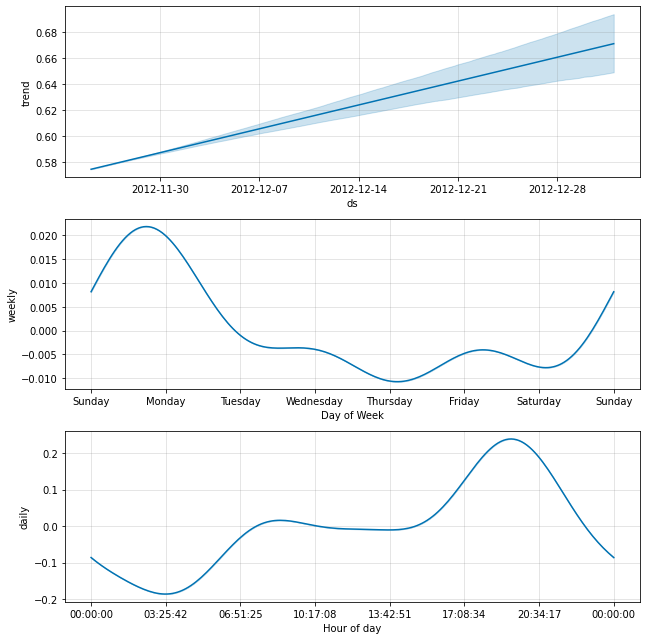

In [10]:
# with plot_components method, we can visualize the data components
model.plot_components(forecast_2012);

In [42]:
len(test_df_2012['ds'].dt.normalize().unique())

37

In [44]:
# Analysis with cross validation method
# This cell takes some minutes.
df_cv_2012 = cross_validation(model, horizon='36 days')
df_cv_2012.head()

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.

In [37]:
# With performance_metrics, we can visualize the score
df_p_2012 = performance_metrics(df_cv_2012)

NameError: name 'df_cv_2012' is not defined

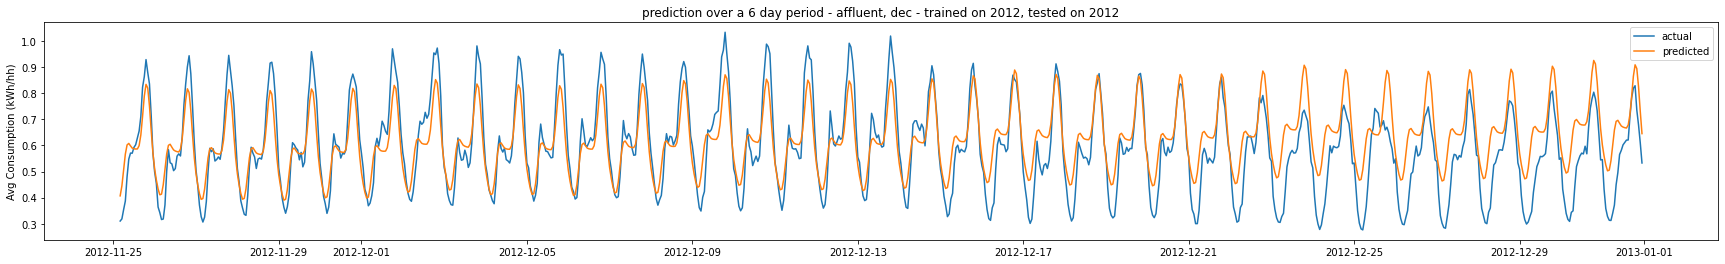

In [11]:
plt.figure(figsize=(30, 4))
plt.plot(answer_df_2012['ds'], answer_df_2012['y'], label='actual')
plt.plot(forecast_2012['ds'], forecast_2012['yhat'], label='predicted')
plt.title('prediction over a 6 day period - affluent, dec - trained on 2012, tested on 2012')
plt.ylabel('Avg Consumption (kWh/hh)')
plt.legend()
plt.show()

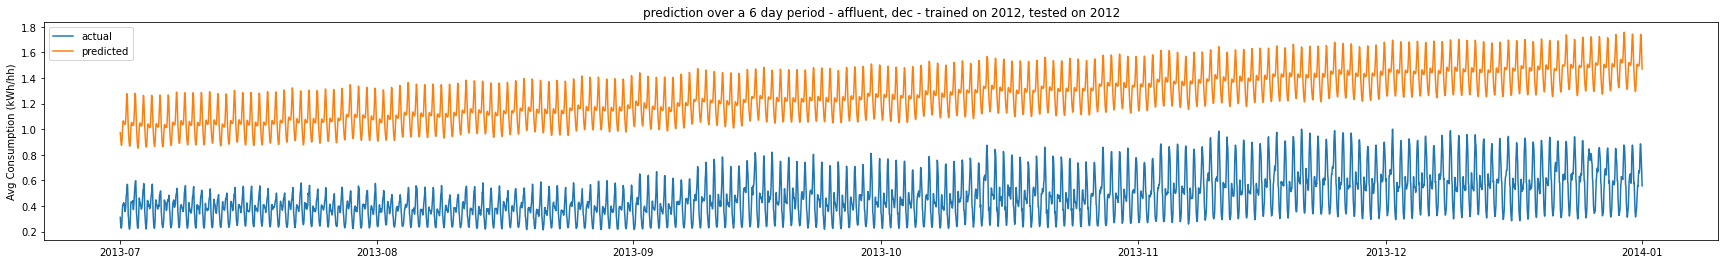

In [82]:
plt.figure(figsize=(30, 4))
plt.plot(answer_df_2013['ds'], answer_df_2013['y'], label='actual')
plt.plot(forecast_2013['ds'], forecast_2013['yhat'], label='predicted')
plt.title('prediction over a 6 day period - affluent, dec - trained on 2012, tested on 2012')
plt.ylabel('Avg Consumption (kWh/hh)')
plt.legend()
plt.show()

In [200]:
print('me:', me(answer_df_2012['y'], forecast_2012_w_reg['yhat']))
print('mpe:', mpe(answer_df_2012['y'], forecast_2012_w_reg['yhat'])*100)

me: 47.71706189459017
mpe: 18.89217324373148


In [78]:
train_size = 0
X_train, X_test = affluent_2013[:train_size].index, affluent_2013[train_size:].index
y_train, y_test = affluent_2013[:train_size]['kWh/hh'].values, affluent_2013[train_size:]['kWh/hh'].values
reg_train, reg_test = affluent_2013[:train_size]['temp'].values, affluent_2013[train_size:]['temp'].values

In [79]:
train_df_2013 = pd.concat([pd.Series(X_train), pd.Series(y_train), pd.Series(reg_train)], axis=1, keys=['ds', 'y', 'temp'])
test_df_2013 = pd.concat([pd.Series(X_test), pd.Series([0]*len(y_test)), pd.Series(reg_test)], axis=1, keys=['ds', 'y', 'temp'])
answer_df_2013 = pd.concat([pd.Series(X_test), pd.Series(y_test)], axis=1, keys=['ds', 'y'])

In [61]:
forecast_2013.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'extra_regressors_additive',
       'extra_regressors_additive_lower', 'extra_regressors_additive_upper',
       'monthly', 'monthly_lower', 'monthly_upper', 'temp', 'temp_lower',
       'temp_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly',
       'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [80]:
forecast_2013 = model.predict(test_df_2013)

-9.945278665601144


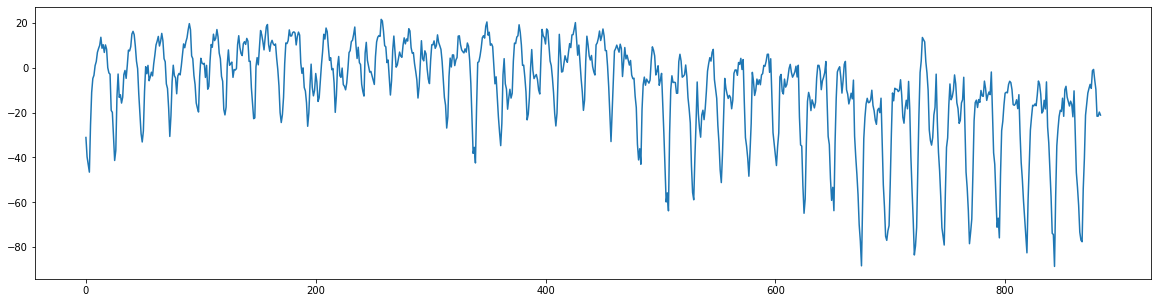

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(((answer_df_2012['y'].values - forecast_2012['yhat'].values)/answer_df_2012['y'].values*100));
print(((answer_df_2012['y'].values - forecast_2012['yhat'].values)/answer_df_2012['y'].values*100).mean())

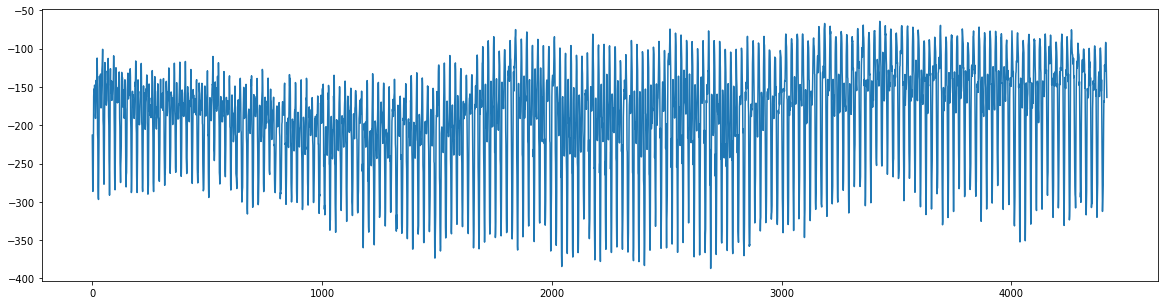

In [90]:
plt.figure(figsize=(20, 5))
plt.plot(((answer_df_2013['y'].values - forecast_2013['yhat'].values)/answer_df_2013['y'].values*100));

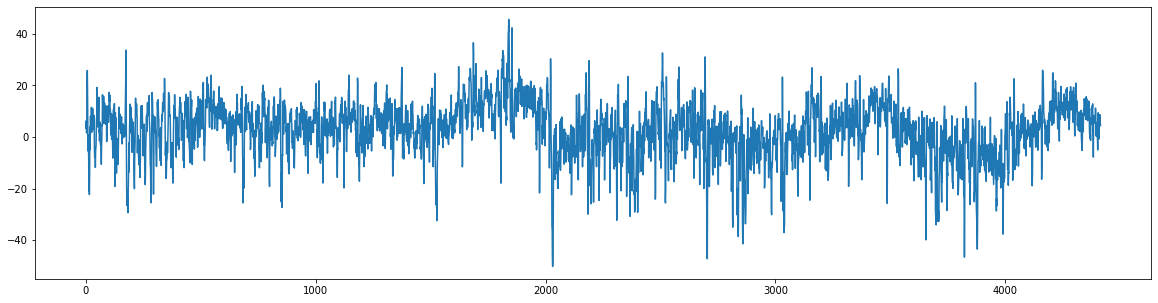

In [89]:
plt.figure(figsize=(20, 5))
plt.plot(((affluent_2013['kWh/hh'].values - affluent_2012['kWh/hh'].values)/affluent_2013['kWh/hh'].values*100));

ValueError: x and y must have same first dimension, but have shapes (744,) and (149,)

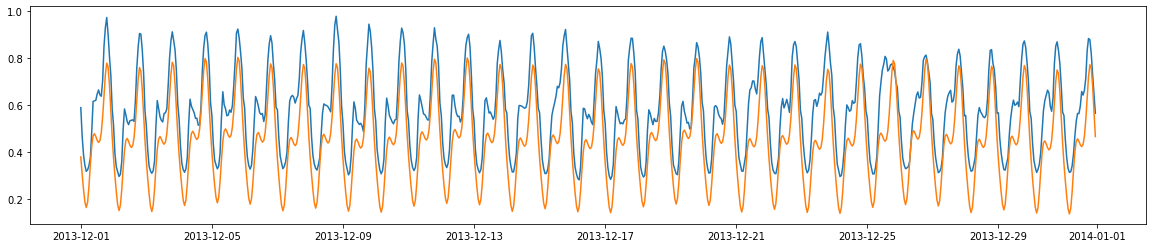

In [151]:
plt.figure(figsize=(20, 4))
plt.plot(answer_df_2013['ds'], answer_df_2013['y'], label='actual')
plt.plot(forecast_2013['ds'], forecast_2013['yhat'], label='predicted')
plt.plot(answer_df_2013['ds'], answer_df_2012['y'], label='actual 2012')
plt.plot(forecast_2013['ds'], forecast_2012['yhat'], label='predicted 2012')
plt.title('prediction over on 2013 from the model trained on 80% of 2012')
plt.ylabel('Avg Consumption (kWh/hh)')
plt.legend()x
plt.show()

In [149]:
((affluent_dec_2013['KWH/hh'].values - block_0_df['KWH/hh'].values)/affluent_dec_2013['KWH/hh'].values).mean()

-0.04771327888966097

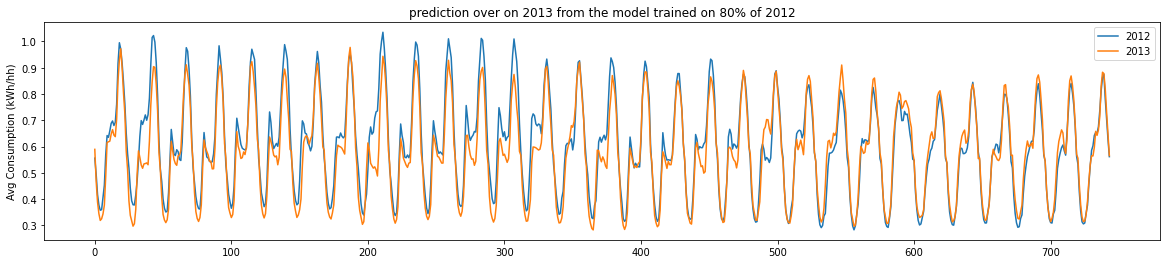

In [143]:
plt.figure(figsize=(20, 4))
plt.plot(block_0_df['KWH/hh'].values, label='2012')
plt.plot(affluent_dec_2013['KWH/hh'].values, label='2013')
plt.title('prediction over on 2013 from the model trained on 80% of 2012')
plt.ylabel('Avg Consumption (kWh/hh)')
plt.legend()
plt.show()

In [107]:
# let's compare error on 2012 vs on 2013
dif_2013 = (answer_df_2013['y'] - forecast_2013['yhat'])
dif_2012 = (answer_df_2012['y'] - forecast_2012['yhat'])

In [101]:
print('avg 2013 error', dif_2013.mean())
print('avg 2012 error', dif_2012.mean())

avg 2013 error 0.12320325587166715
avg 2012 error -0.03116638581396421


In [104]:
print('avg 2013 percent error', dif_2013.mean()*100)
print('avg 2012 percent error', dif_2012.mean()*100)

avg 2013 percent error 23.835332164283262
avg 2012 percent error -5.811467816825688


In [108]:
print('avg 2013 error(all)', dif_2013.mean())
print('avg 2012 error', dif_2012.mean())

avg 2013 error(all) 0.12987524554832952
avg 2012 error -0.03116638581396421


In [106]:
print('avg 2013 percent error (all)', dif_2013.mean()*100)
print('avg 2012 percent error', dif_2012.mean()*100)

avg 2013 percent error (all) 24.569671089790543
avg 2012 percent error -5.811467816825688


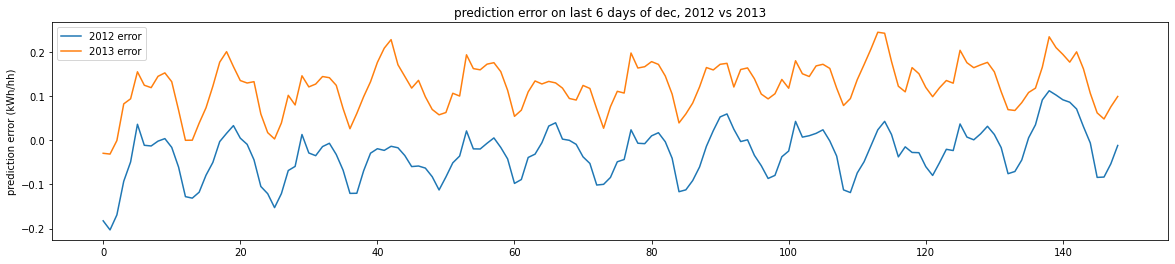

In [100]:
plt.figure(figsize=(20, 4))
plt.plot(dif_2012.values, label='2012 error')
plt.plot(dif_2013.values, label='2013 error')
plt.title('prediction error on last 6 days of dec, 2012 vs 2013')
plt.ylabel('prediction error (kWh/hh)')
plt.legend()
plt.show()

## More advanced model with Prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [187]:
forecast_2012_2_w_reg = model.predict(test_df_2012)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,temp,temp_lower,temp_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-11-25 04:00:00,307.946625,188.155897,255.462772,307.946625,307.946625,-86.667508,-86.667508,-86.667508,-108.010892,...,15.269668,15.269668,15.269668,5.103446,5.103446,5.103446,0.0,0.0,0.0,221.279117
1,2012-11-25 05:00:00,308.003574,212.959302,278.195844,308.003574,308.003574,-64.640250,-64.640250,-64.640250,-86.690350,...,15.269668,15.269668,15.269668,5.747692,5.747692,5.747692,0.0,0.0,0.0,243.363324
2,2012-11-25 06:00:00,308.060523,245.950643,312.625666,308.060523,308.060523,-28.339656,-28.339656,-28.339656,-51.144304,...,15.337852,15.337852,15.337852,6.373758,6.373758,6.373758,0.0,0.0,0.0,279.720867
3,2012-11-25 07:00:00,308.117472,284.001559,347.209070,308.117472,308.117472,9.142395,9.142395,9.142395,-15.732812,...,16.746985,16.746985,16.746985,6.977080,6.977080,6.977080,0.0,0.0,0.0,317.259867
4,2012-11-25 08:00:00,308.174421,306.949783,372.671803,308.174421,308.174421,32.346045,32.346045,32.346045,6.270556,...,17.315184,17.315184,17.315184,7.553279,7.553279,7.553279,0.0,0.0,0.0,340.520466


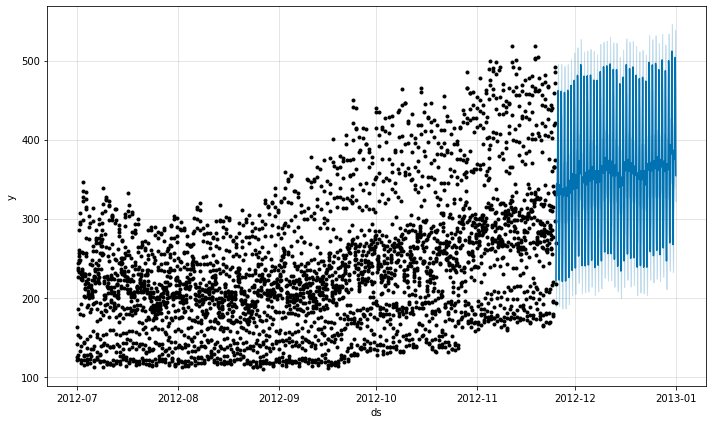

In [189]:
model.plot(forecast_2012_2_w_reg);

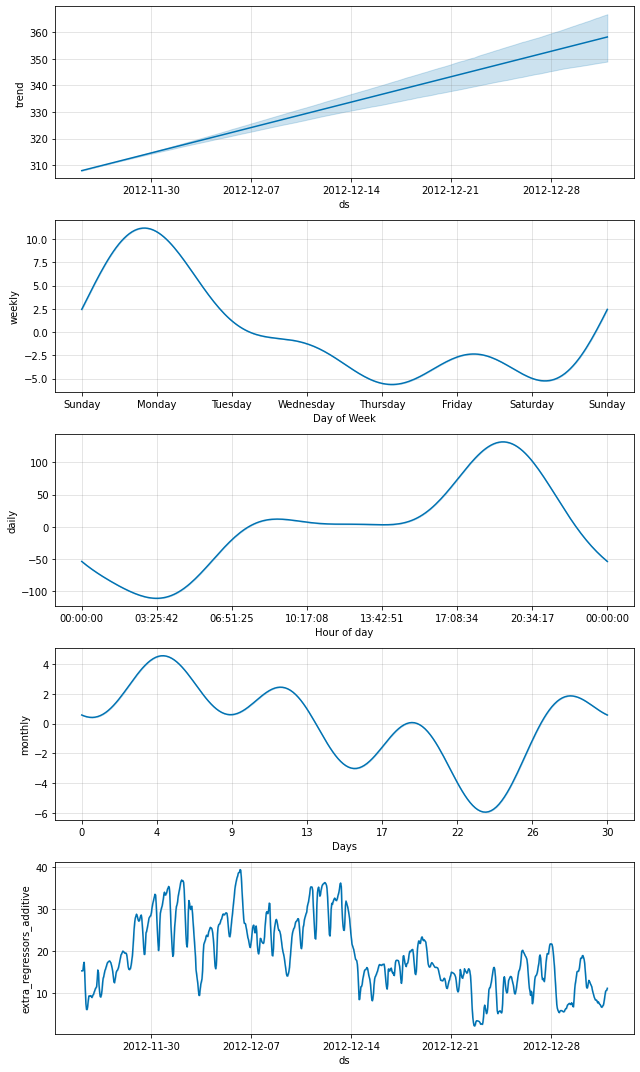

In [190]:
model.plot_components(forecast_2012_2_w_reg);

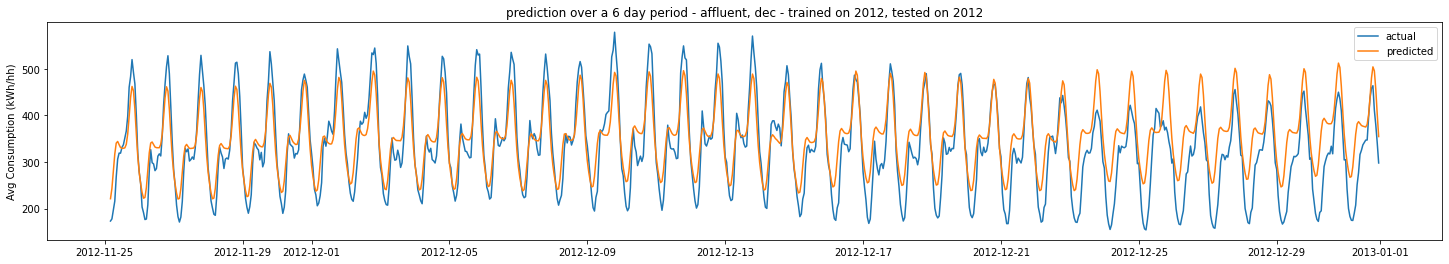

In [194]:
plt.figure(figsize=(25, 4))
plt.plot(answer_df_2012['ds'], answer_df_2012['y'], label='actual')
plt.plot(forecast_2012_2_w_reg['ds'], forecast_2012_2_w_reg['yhat'], label='predicted')
plt.title('prediction over a 6 day period - affluent, dec - trained on 2012, tested on 2012')
plt.ylabel('Avg Consumption (kWh/hh)')
plt.legend()
plt.show()

In [199]:
print('me:', me(answer_df_2012['y'], forecast_2012_2_w_reg['yhat']))
print('mpe:', mpe(answer_df_2012['y'], forecast_2012_2_w_reg['yhat'])*100)

me: 47.934605198589196
mpe: 19.256429799266932


In [203]:
# add daily seasonality
model = Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=True, growth='logistic')
model.add_regressor('temp')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
train_df['cap'] = 0.25
train_df['floor'] = 0.1
model.fit(train_df_2012)

ValueError: Capacities must be supplied for logistic growth in column "cap"

In [ ]:
test_df['cap'] = 0.25
test_df['floor'] = 0.1
forecast = model.predict(test_df)
forecast.head()

In [ ]:
model.plot(forecast)

In [ ]:
model.plot_components(forecast)

In [ ]:
df_cv = cross_validation(model, horizon='60 days')
df_cv.head()

In [ ]:
df_p = performance_metrics(df_cv)
df_p

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(answer_df['ds'], answer_df['y'])
plt.plot(forecast['ds'], forecast['yhat'])

In [ ]:
# holiday_df = pd.read_csv('../Data/uk_bank_holidays.csv', names=('ds', 'holiday'), header=0)
# holiday_df.head()

In [ ]:
# # add daily seasonality
# model = Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=True, 
#                 growth='logistic', holidays=holiday_df, changepoint_prior_scale=0.2)
# model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# train_df['cap'] = 0.25
# train_df['floor'] = 0.1
# model.fit(train_df)

In [ ]:
test_df['cap'] = 0.25
test_df['floor'] = 0.1
forecast = model.predict(test_df)
forecast.head()

In [ ]:
model.plot(forecast)

In [ ]:
model.plot_components(forecast)

In [ ]:
df_cv = cross_validation(model, horizon='60 days')
df_cv.head()

In [ ]:
df_p = performance_metrics(df_cv)
df_p

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(answer_df['ds'], answer_df['y'])
plt.plot(forecast['ds'], forecast['yhat'])